# Carvana Case

In [1]:
# import all the libraries and packages which we may need as part of the data processing and analysis
from pathlib import Path # to interact with file system.
#from dmba import regressionSummary
import numpy as np # for working with arrays.
import pandas as pd # for working with data frames (tables).
import statsmodels.api as sm

from sklearn.model_selection import train_test_split # for data partition.
from sklearn.metrics import r2_score # to identify r_squared for regression model.
from sklearn.linear_model import LinearRegression # for linear regression model.

%matplotlib inline 
#renders the figure in a notebook
import matplotlib.pylab as plt


pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
#Create a data frame in Python using training file.
carvana_df = pd.read_csv('training.csv')
carvana_df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [3]:
# Set correct formatting
carvana_df['PurchDate'] = pd.to_datetime(carvana_df['PurchDate'], format= '%m/%d/%Y')

# Fill NA values in the AUCGUART
carvana_df['AUCGUART'] = carvana_df['AUCGUART'].fillna('NA')

# Calculate the difference between vehicle purchase cost and Acq. Auction Average
carvana_df['square_sum_price_and_aqu_price'] = (carvana_df['VehBCost'] - carvana_df['MMRAcquisitionAuctionAveragePrice'])

### 1a. Using visual analytics identify some leading indicators of a bad buy.

In [4]:
# Grouping by make and determine aggregations for IsBadBuy variable 
avg_bad_buy = carvana_df.groupby(['Make'])['IsBadBuy'].agg(['sum','count','mean']).reset_index()
avg_bad_buy.columns = ['Make','bad', 'total', 'avg_bad']
avg_bad_buy.head()

,Make,bad,total,avg_bad
0,ACURA,9,33,0.272727
1,BUICK,113,720,0.156944
2,CADILLAC,5,33,0.151515
3,CHEVROLET,1681,17248,0.097461
4,CHRYSLER,1137,8844,0.128562


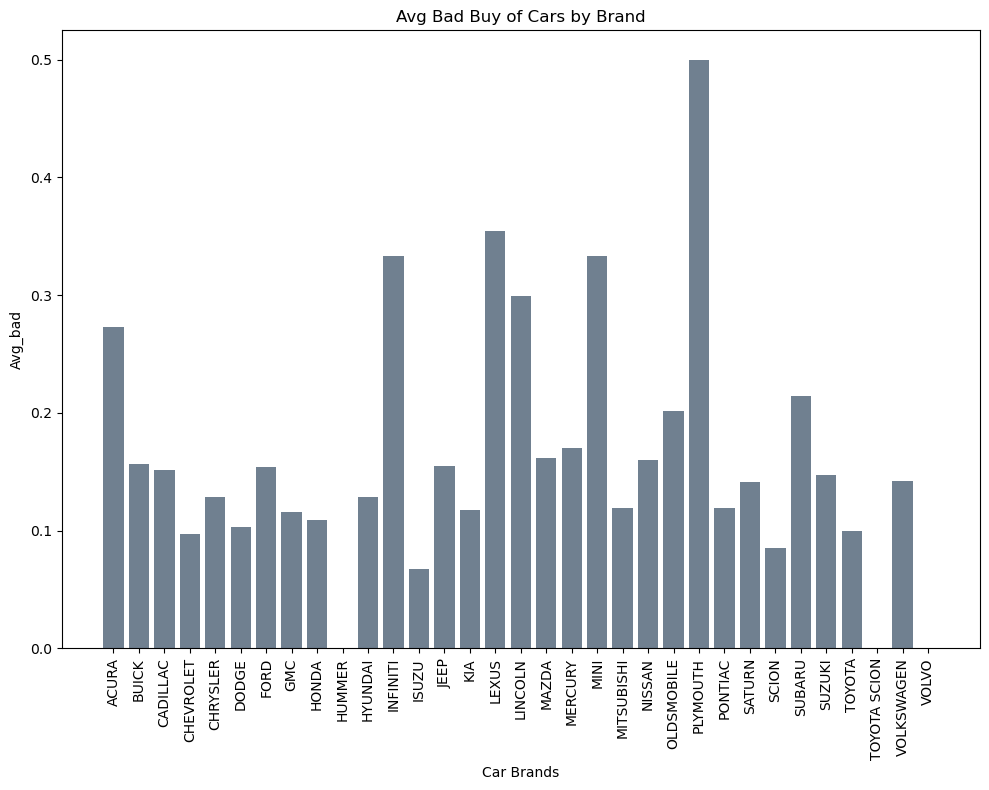

In [5]:
# Plot the above information in a bar graph
plt.figure(figsize=(10, 8))
plt.bar(avg_bad_buy['Make'], avg_bad_buy['avg_bad'], color='slategrey')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel("Car Brands")
plt.ylabel("Avg_bad")
plt.title("Avg Bad Buy of Cars by Brand")
plt.tight_layout()
plt.show()

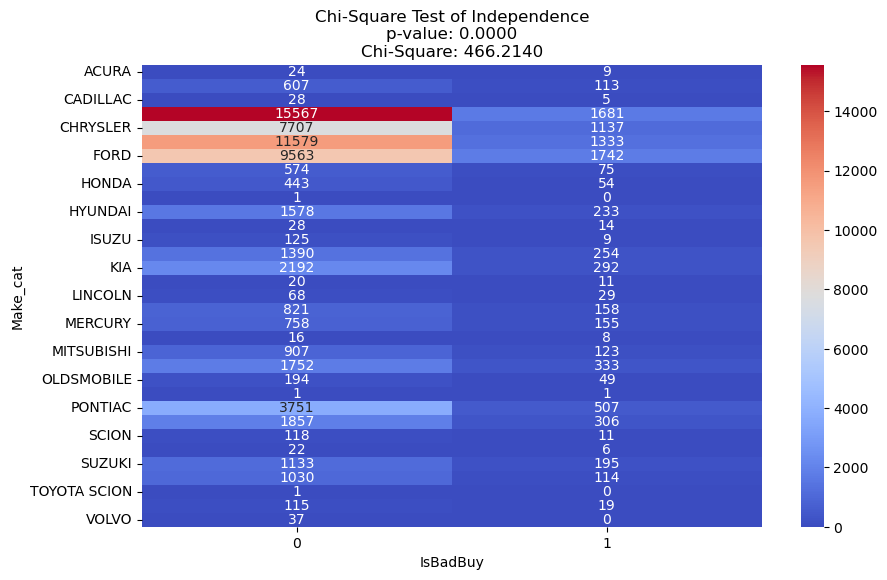

In [6]:
# Check if there is any correlation between make and badBuy
carvana_df['Make_cat'] = carvana_df['Make'].astype('category')
#carvana_df['Make_cat'].corr(carvana_df['IsBadBuy'])
#carvana_df['Make_cat']
contingency_table = pd.crosstab(carvana_df['Make_cat'], carvana_df['IsBadBuy'])
#print(contingency_table)
chi2,p,_,_ = chi2_contingency(contingency_table)
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='coolwarm')
plt.title(f'Chi-Square Test of Independence\np-value: {p:.4f}\nChi-Square: {chi2:.4f}')
plt.show()

### Observation - Make & Category (Chi Squared Test of Independence)

Based on the above we can see that p value is less than 0.05 and shows a string correlation between bad buy and model. Chi Square value is also very high.

Pontiac shows great %age of cars with higher bad buys wrt to rest of the cars. It could be because of some other reasons as well however it does show interesting observation has to be considered for more furrther analysis

In [7]:
# Grouping by make and determine aggregations for IsBadBuy variable 
acquisition_type = carvana_df.groupby('AUCGUART')['IsBadBuy'].agg(['sum','count','mean']).reset_index()
acquisition_type.columns = ['AUCGUART', 'bad', 'total', 'avg_bad']
acquisition_type

,AUCGUART,bad,total,avg_bad
0,GREEN,125,3340,0.037425
1,NA,8843,69564,0.127120
2,RED,8,79,0.101266


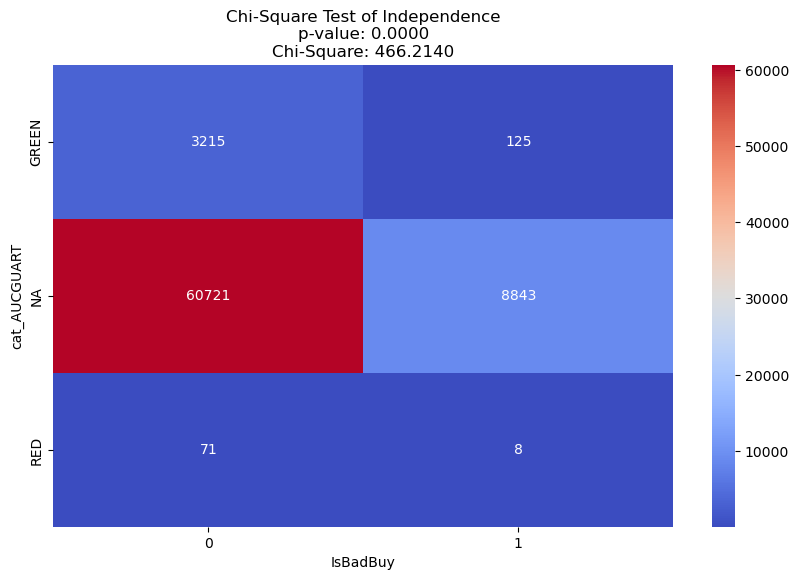

In [8]:
# Evaluate if the above information has any correlation 
carvana_df['cat_AUCGUART'] = carvana_df['AUCGUART'].astype('category')
AUCGUART_contingency_table = pd.crosstab(carvana_df['cat_AUCGUART'],carvana_df['IsBadBuy'])
chi2_auc,p_auc,_1,_2 = chi2_contingency(AUCGUART_contingency_table)
plt.figure(figsize=(10, 6))
sns.heatmap(AUCGUART_contingency_table, annot=True, fmt='d', cmap='coolwarm')
plt.title(f'Chi-Square Test of Independence\np-value: {p:.4f}\nChi-Square: {chi2:.4f}')
plt.show()

### Observation - AUCGUART & Category (Chi Squared Test of Independence)

From the above if the AUCGUART says light is green then there are lower chances of bad vehicle however, if we have unknown or NA light information or if its RED then there could be higher chances for it being a bad buy. Also this coincide with general knowledge if the warning light is on a vehicle chances of it being bad increases.

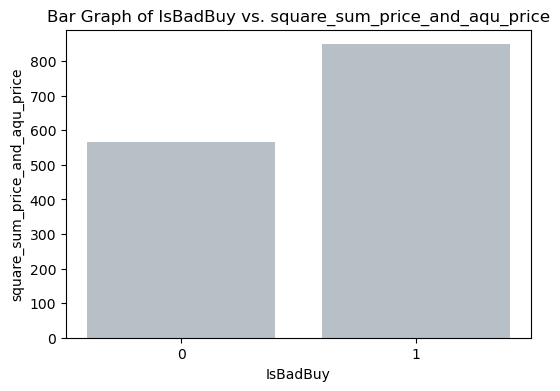

In [9]:
avg_price_df = carvana_df.groupby('IsBadBuy')['square_sum_price_and_aqu_price'].agg('mean').reset_index()
avg_price_df.columns = ['IsBadBuy', 'square_sum_price_and_aqu_price']
#print(avg_price_df)

plt.figure(figsize=(6, 4))
plt.bar(avg_price_df['IsBadBuy'], avg_price_df['square_sum_price_and_aqu_price'], color='slategrey', alpha=0.5)
plt.xlabel("IsBadBuy")
plt.ylabel("square_sum_price_and_aqu_price")
plt.xticks(avg_price_df['IsBadBuy'])
plt.title("Bar Graph of IsBadBuy vs. square_sum_price_and_aqu_price")
plt.show()

BYRNO
835      0.119518
1031     0.064516
1035     0.100000
1041     0.250000
1045     0.209677
           ...   
99740    0.128280
99741    1.000000
99750    0.029778
99760    1.000000
99761    0.056049
Length: 74, dtype: float64


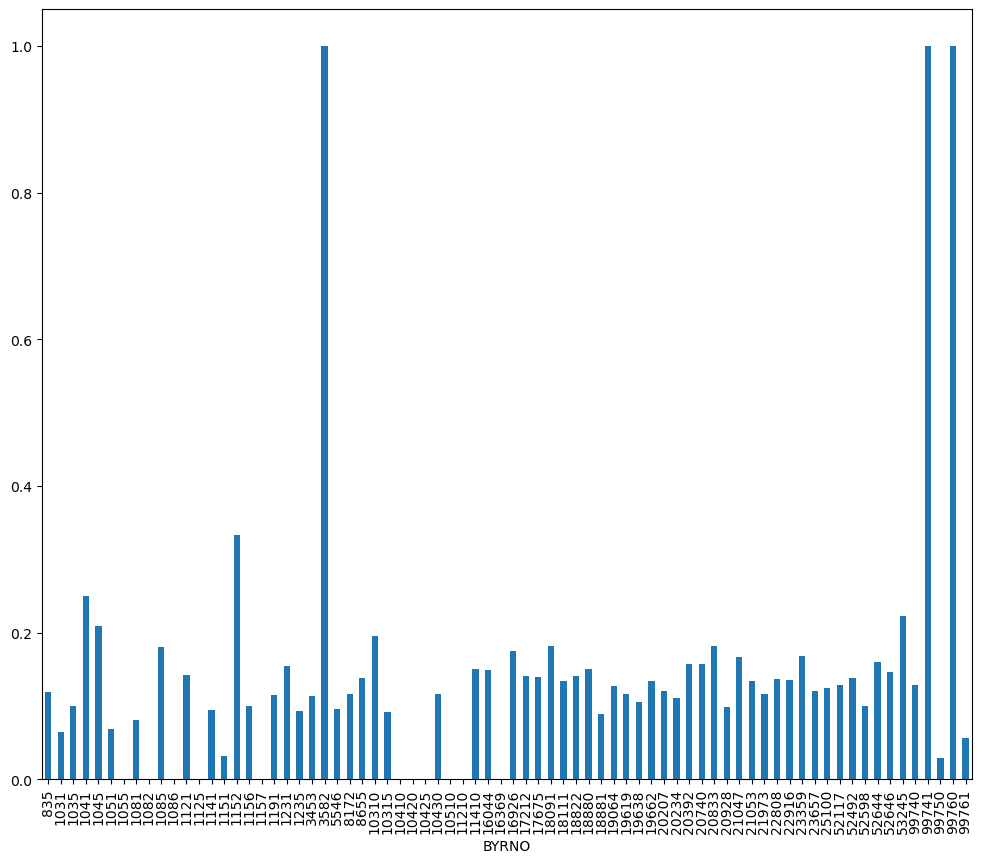

In [10]:
plt.figure(figsize=(12, 10))
query_result = carvana_df
grouped_data = carvana_df.groupby('BYRNO')['IsBadBuy'].sum() 
grouped_data = grouped_data / carvana_df.groupby('BYRNO')['RefId'].count()
print(grouped_data)
grouped_data.plot(kind='bar')
plt.xlabel('BYRNO')
plt.show()

### Observation - BUYERNO.
We've created visual representations to determine the proportion of faulty cars based on their BUYERNO. This involves calculating the ratio of defective cars that come from a BUYERNO in comparison to the total number of cars from that specific BUYERNO. The idea here that a certain buyer may be more predisposed to selling faulty cars. I.e - cars from a high flood area or cars from a source that neglects maintenance



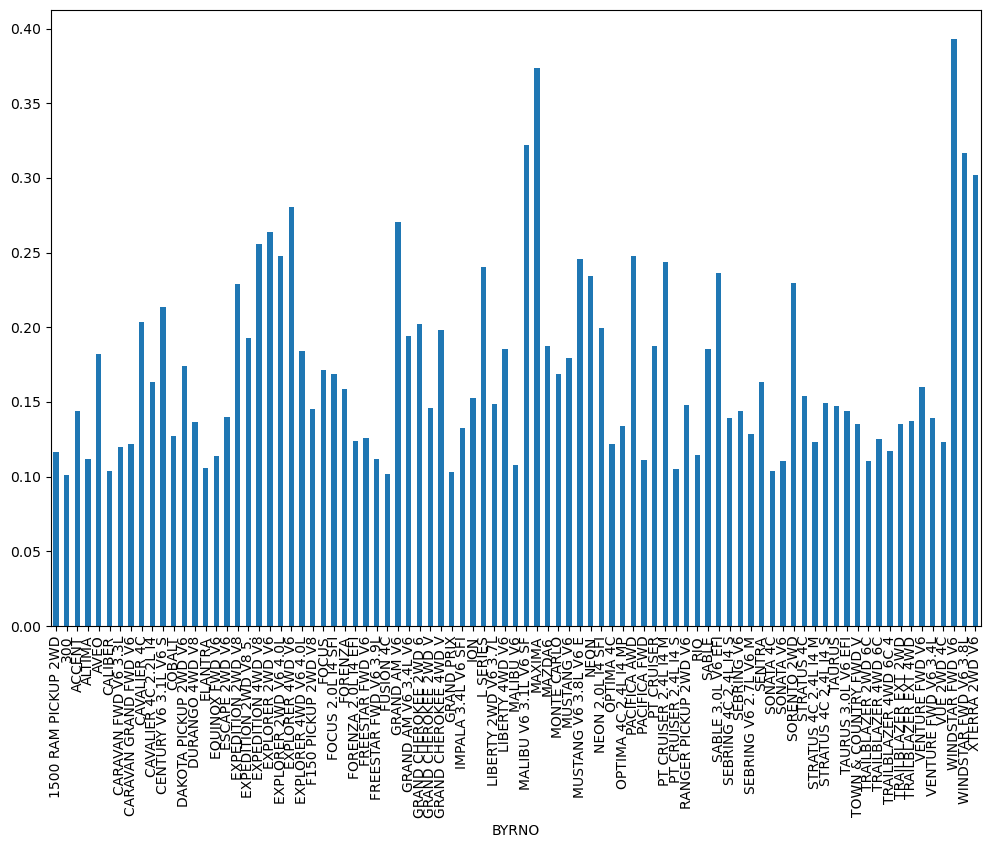

Model
1500 RAM PICKUP 2WD     0.116258
300                     0.101266
ACCENT                  0.143750
ALTIMA                  0.111601
AVEO                    0.182292
                          ...   
VENTURE FWD V6 3.4L     0.139394
VUE 2WD 4C              0.123529
WINDSTAR FWD V6         0.392857
WINDSTAR FWD V6 3.8L    0.316901
XTERRA 2WD V6           0.301887
Length: 87, dtype: float64

In [11]:
plt.figure(figsize=(12, 8))
query_result = carvana_df[carvana_df['IsBadBuy'] == 1]
grouped_data = carvana_df.groupby('Model')['IsBadBuy'].sum() 
grouped_data = grouped_data[grouped_data > 20]
grouped_data = grouped_data / carvana_df.groupby('Model')['RefId'].count()
grouped_data = grouped_data[grouped_data > .10]
grouped_data.plot(kind='bar')
plt.xlabel('BYRNO')
plt.show()

grouped_data

### Observation - BUYERNO.

We've created visual representations to determine the proportion of faulty cars based on their MODELS. This involves calculating the ratio of defective cars per model in comparison to the total number of cars within each model category. The idea here that a certain model of a car might be faulty from an engineering standpoint and not something worthwhile in investing.

/var/folders/t6/62p5k1w921vdm0907xrsq0ph0000gn/T/ipykernel_20448/1683278578.py:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = corr.corr()


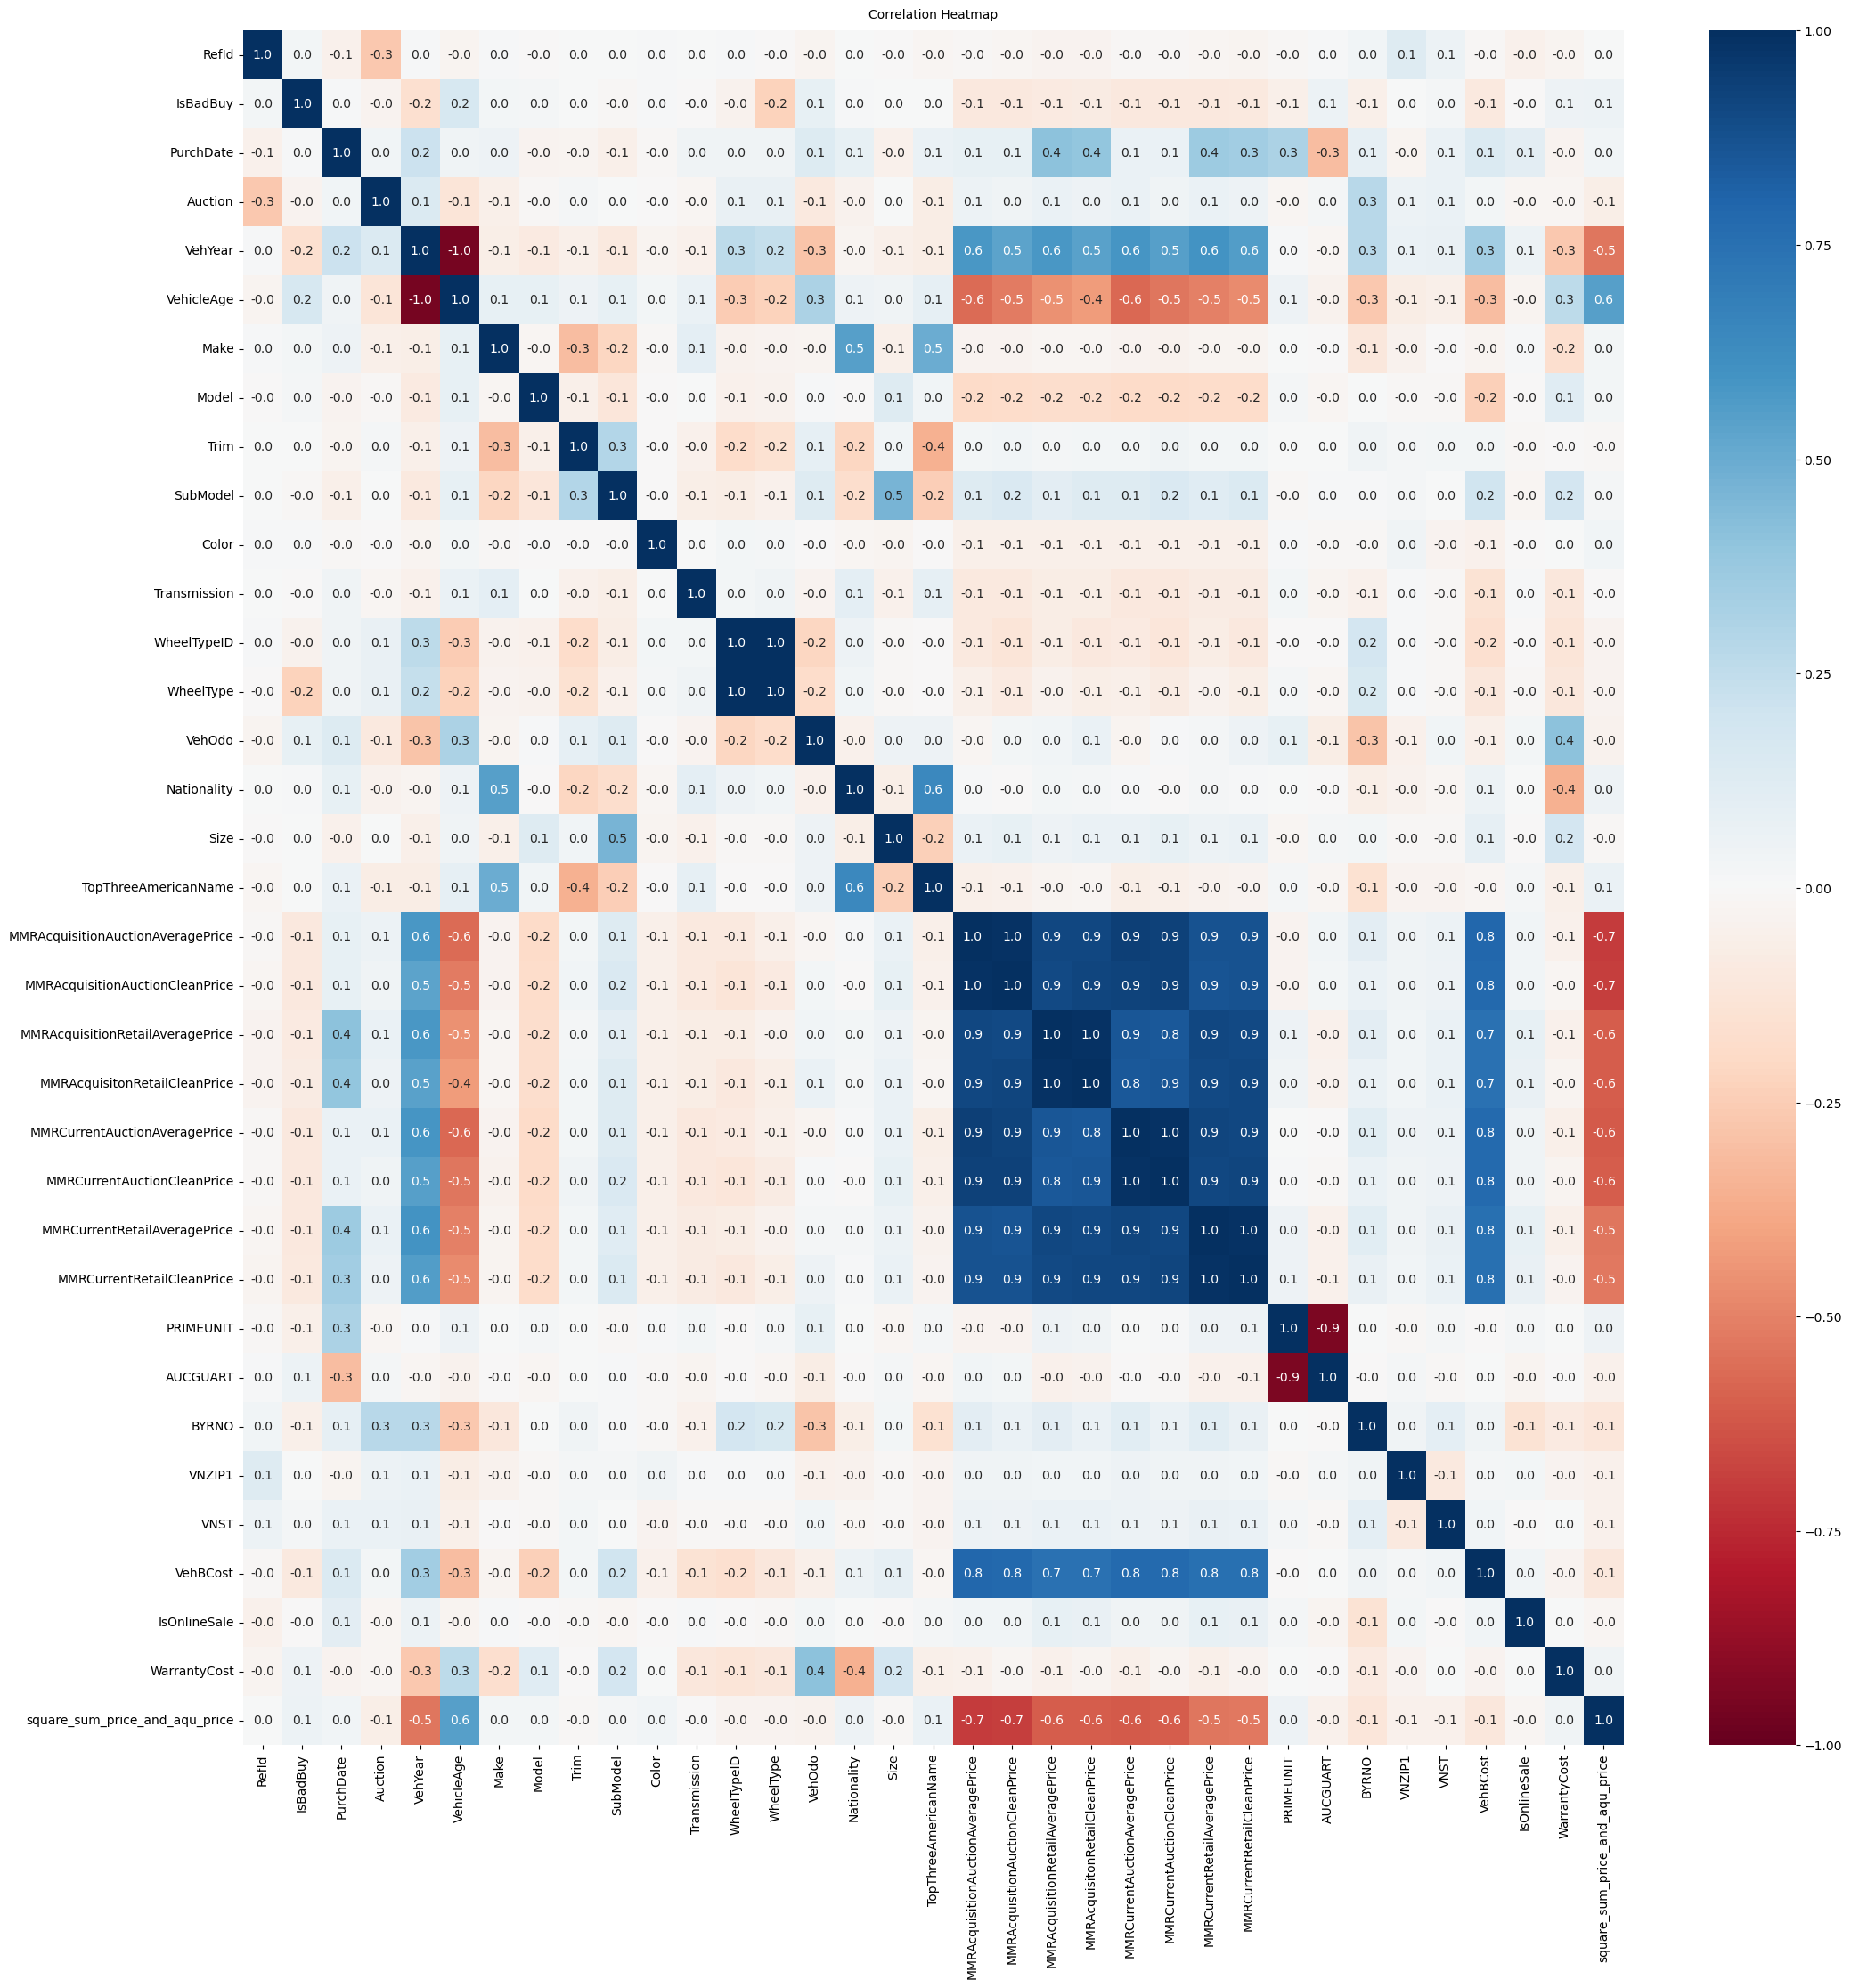

In [12]:
# Create a copy of the carvana_df DataFrame
corr = carvana_df

# Convert categorical variables to numerical codes
corr['IsBadBuy'] = corr['IsBadBuy'].astype('category').cat.codes
corr['Auction'] = corr['Auction'].astype('category').cat.codes
corr['Make'] = corr['Make'].astype('category').cat.codes
corr['Model'] = corr['Model'].astype('category').cat.codes
corr['Trim'] = corr['Trim'].astype('category').cat.codes
corr['SubModel'] = corr['SubModel'].astype('category').cat.codes
corr['PurchDate'] = corr['PurchDate'].astype('category').cat.codes
corr['Color'] = corr['Color'].astype('category').cat.codes
corr['Transmission'] = corr['Transmission'].astype('category').cat.codes
corr['WheelType'] = corr['WheelType'].astype('category').cat.codes
corr['Nationality'] = corr['Nationality'].astype('category').cat.codes
corr['Size'] = corr['Size'].astype('category').cat.codes
corr['TopThreeAmericanName'] = corr['TopThreeAmericanName'].astype('category').cat.codes
corr['Size'] = corr['Size'].astype('category').cat.codes
corr['VNST'] = corr['VNST'].astype('category').cat.codes
corr['PRIMEUNIT'] = corr['PRIMEUNIT'].astype('category').cat.codes
corr['AUCGUART'] = corr['AUCGUART'].astype('category').cat.codes

# Correlation matrix
corr = corr.corr()

# Create heatmap
plt.figure(figsize=(25, 25)) # Set figure size
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt=".1f", cmap="RdBu") # Create heatmap using Seaborn
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=10);

### 1b. Summarize your recommendations for Carvana.

# Airfares

### 2a. Explore the relationship between FARE and other numerical predictors. Summarize your  observations. 

In [13]:
airfares_df = pd.read_csv('Airfares.csv')
airfares_df = airfares_df.drop(columns=['S_CODE','S_CITY','E_CODE','E_CITY'])

airfares_df.head()

,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,1.00,3,No,Yes,5291.99,28637.0,21112.0,3036732,205711,Free,Free,312,7864,64.11
1,1.06,3,No,No,5419.16,26993.0,29838.0,3532657,7145897,Free,Free,576,8820,174.47
2,1.06,3,No,No,9185.28,30124.0,29838.0,5787293,7145897,Free,Free,364,6452,207.76
3,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Controlled,Free,612,25144,85.47
4,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Free,Free,612,25144,85.47


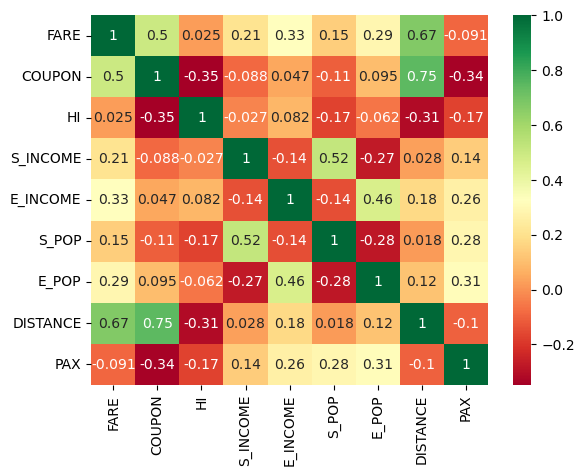

In [14]:
# Plot the correlation matrix
num_df = airfares_df[['FARE','COUPON','HI','S_INCOME','E_INCOME','S_POP','E_POP','DISTANCE','PAX']]
sns.heatmap(num_df.corr(), annot=True, cmap='RdYlGn')
plt.show()

<B> Observations - Airfare correlation

If we look at the above heatmap it can be noticed that distance and coupon are correlated among themselves. This could be due to the fact that since fare ahs shown soe correlation bwith the distance, hence more the fare more the discount and hence more the distance. 



### 2b. Use various tables to analyze the effect of categorical predictors on FARE. 

In [15]:
new_df = pd.get_dummies(airfares_df, prefix_sep = '_', drop_first=True)
new_df.head()

,COUPON,NEW,HI,S_INCOME,E_INCOME,S_POP,E_POP,DISTANCE,PAX,FARE,VACATION_Yes,SW_Yes,SLOT_Free,GATE_Free
0,1.00,3,5291.99,28637.0,21112.0,3036732,205711,312,7864,64.11,0,1,1,1
1,1.06,3,5419.16,26993.0,29838.0,3532657,7145897,576,8820,174.47,0,0,1,1
2,1.06,3,9185.28,30124.0,29838.0,5787293,7145897,364,6452,207.76,0,0,1,1
3,1.06,3,2657.35,29260.0,29838.0,7830332,7145897,612,25144,85.47,0,1,0,1
4,1.06,3,2657.35,29260.0,29838.0,7830332,7145897,612,25144,85.47,0,1,1,1


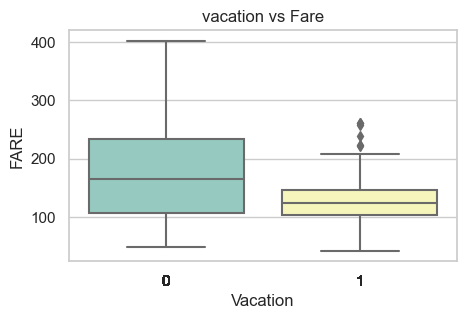

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.boxplot(x='VACATION_Yes', y = 'FARE', data= new_df, palette="Set3")
plt.xlabel("Vacation")
plt.ylabel("FARE")
plt.title("vacation vs Fare")
plt.xticks(new_df['VACATION_Yes'])
plt.show()


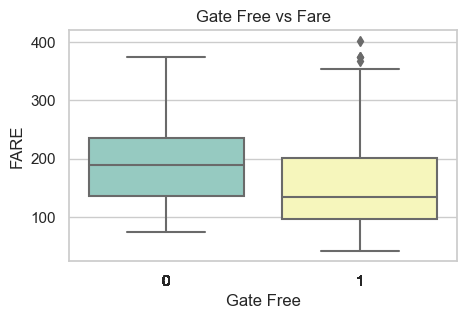

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.boxplot(x='GATE_Free', y = 'FARE', data= new_df, palette="Set3")
plt.xlabel("Gate Free")
plt.ylabel("FARE")
plt.title("Gate Free vs Fare")
plt.xticks(new_df['GATE_Free'])
plt.show()


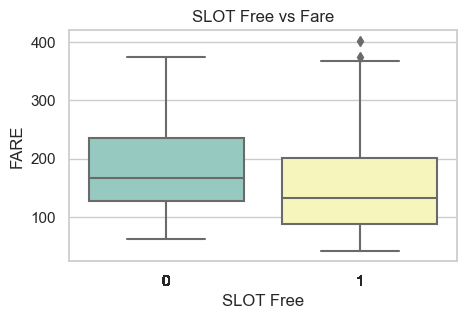

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.boxplot(x='SLOT_Free', y = 'FARE', data= new_df, palette="Set3")
plt.xlabel("SLOT Free")
plt.ylabel("FARE")
plt.title("SLOT Free vs Fare")
plt.xticks(new_df['SLOT_Free'])
plt.show()

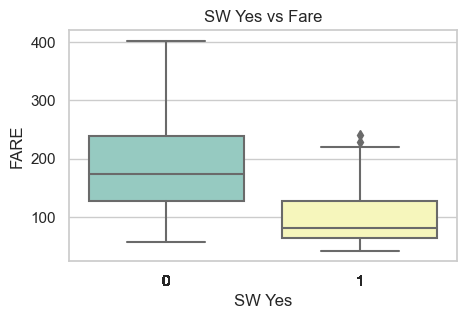

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.boxplot(x='SW_Yes', y = 'FARE', data= new_df, palette="Set3")
plt.xlabel("SW Yes")
plt.ylabel("FARE")
plt.title("SW Yes vs Fare")
plt.xticks(new_df['SW_Yes'])
plt.show()

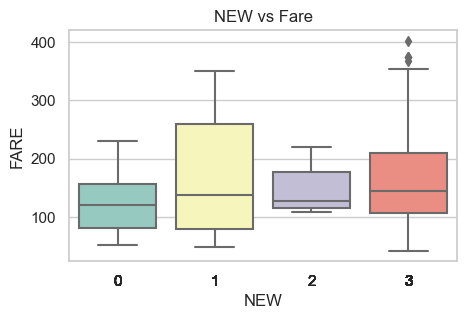

In [20]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.boxplot(x='NEW', y = 'FARE', data= new_df, palette="Set3")
plt.xlabel("NEW")
plt.ylabel("FARE")
plt.title("NEW vs Fare")
plt.xticks(new_df['NEW'])
plt.show()

In [21]:
X2 = new_df[['VACATION_Yes','SW_Yes','SLOT_Free','GATE_Free']]
X2 = sm.add_constant(X2)
model = sm.OLS(new_df['FARE'], X2).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   FARE   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     92.78
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           4.49e-62
Time:                        17:42:04   Log-Likelihood:                -3520.8
No. Observations:                 638   AIC:                             7052.
Df Residuals:                     633   BIC:                             7074.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          213.6555      7.168     29.809      0.000     199.581     227.730
VACATION_Yes   -42.9095      5.529     -7.761      0.000     -53.767     -32.053
SW_Yes         -83.9268      5.661    -14.825      0.000     -95.044     -72.810
SLOT_Free       -9.6731      5.697     -1.698      0.090     -20.861       1.515
GATE_Free      -11.0614      6.498     -1.702      0.089     -23.822       1.699
==============================================================================
Omnibus:                       26.864   Durbin-Watson:                   1.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.527
Skew:                           0.521   Prob(JB):                     3.88e-07
Kurtosis:                       2.848   Cond. No.                         6.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b> Observation

From the above table it shows that Vacation and SW have p value less that 0.05 which shoes there could be a correlation between Vacation and SW with the fare. 

So let me remove the two SLOT_FREE and GATE_Free from the model to see if it changes or improves teh R2 as well as p

In [22]:
X1 = new_df[['VACATION_Yes','SW_Yes']]
X1 = sm.add_constant(X1)
model = sm.OLS(new_df['FARE'], X1).fit()
summary1 = model.summary()
summary1

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   FARE   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     182.5
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           2.46e-63
Time:                        17:42:04   Log-Likelihood:                -3523.1
No. Observations:                 638   AIC:                             7052.
Df Residuals:                     635   BIC:                             7066.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          199.8950      3.205     62.363      0.000     193.601     206.189
VACATION_Yes   -45.2194      5.435     -8.319      0.000     -55.893     -34.546
SW_Yes         -88.6928      5.224    -16.979      0.000     -98.951     -78.435
==============================================================================
Omnibus:                       22.862   Durbin-Watson:                   1.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.550
Skew:                           0.470   Prob(JB):                     4.67e-06
Kurtosis:                       2.801   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The adjusted R2 value suggests these coefficients explain around 36% variability in prediction.


<b> Conclusion


1. It is evident from the Vacation and Fare box plot it seems people on vacation tends to pay lesser, and one could be the reason of booking the flights a bit earlier. This does impacts the prices and hence the people on vacation trip which may happen more unplanned seems to pay a bit higher on average. 

2. Gate Free tends to pay lesser then non gate free.

3. From the SW_Free it seems the PAX with SW as free tends to pay less in comparision to other PAX

Same was identified by model as well to so 36% of the variability was identified on the whole data.

### 2c. Develop a model to predict FARE. Summarize the accuracy measures based on the validation data. What is the final model you would recommend to predict FARE?

In [23]:
new_df.columns

Index(['COUPON', 'NEW', 'HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP',
       'DISTANCE', 'PAX', 'FARE', 'VACATION_Yes', 'SW_Yes', 'SLOT_Free',
       'GATE_Free'],
      dtype='object')

In [24]:
# partition data
X = new_df[['DISTANCE','VACATION_Yes','SW_Yes']]#,'VACATION_Yes','SW_Yes'
y = new_df['FARE']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

model = LinearRegression()
model.fit(train_X, train_y)

train_pred = model.predict(train_X)
r2 = model.score(valid_X, valid_y)
print(r2)
train_results = pd.DataFrame({
    'FARE': train_y, 
    'predicted': train_pred, 
    'residual': train_y - train_pred
})
print(train_results.head())

0.70504171904171
       FARE   predicted   residual
487  374.40  310.450523  63.949477
110  139.56  129.756474   9.803526
447  128.36  136.931094  -8.571094
363  186.28  158.913838  27.366162
434   69.60  152.029101 -82.429101


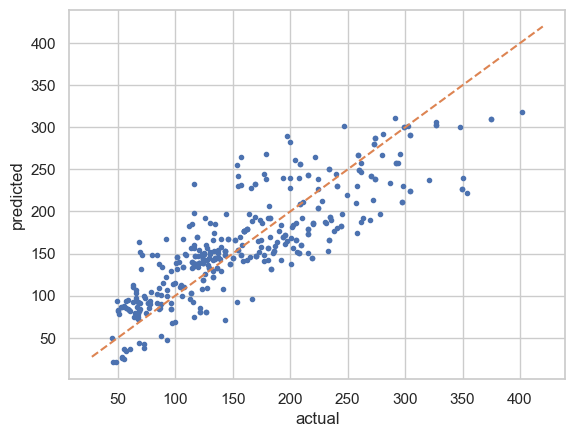

In [25]:
plt.plot(train_results.FARE, train_results.predicted, '.')
plt.xlabel('actual')  # set x-axis label
plt.ylabel('predicted')  # set y-axis label
axes = plt.gca()
plt.plot(axes.get_xlim(), axes.get_xlim(), '--')
plt.show()

In [26]:
valid_pred = model.predict(valid_X)
valid_results = pd.DataFrame({
    'FARE': valid_y, 
    'predicted': valid_pred, 
    'residual': valid_y - valid_pred
})
print(valid_results.head())

       FARE   predicted   residual
101  240.88  180.365229  60.514771
619  347.82  299.869769  47.950231
616  279.83  266.678090  13.151910
446  128.36  136.931094  -8.571094
522  289.25  298.637764  -9.387764


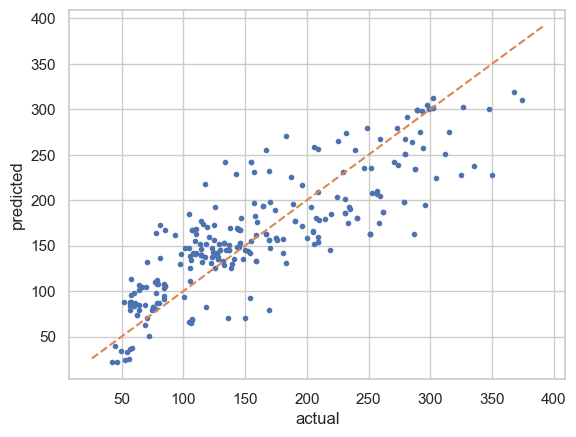

In [27]:
plt.plot(valid_results.FARE, valid_results.predicted, '.')
plt.xlabel('actual')  # set x-axis label
plt.ylabel('predicted')  # set y-axis label
axes = plt.gca()
plt.plot(axes.get_xlim(), axes.get_xlim(), '--')
plt.show()

<b> Error metrics
    
We can use the metrics that scikit-learn provides.

In [28]:
print('Training set r2: ', r2_score(train_results.FARE, train_results.predicted))
print('Validation set r2: ', r2_score(valid_results.FARE, valid_results.predicted))

Training set r2:  0.7092171755252248
Validation set r2:  0.70504171904171


### 2d. Suppose a new airport is brought into service. Airlines have received news and areworking on their prices. Would your model be helpful for them? Why or why not?

In [29]:
# Import the utility function regressionSummary
from dmba import regressionSummary

# training set
regressionSummary(train_results.FARE, train_results.predicted)

# validation set
regressionSummary(valid_results.FARE, valid_results.predicted)

no display found. Using non-interactive Agg backend

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 40.0635
            Mean Absolute Error (MAE) : 31.7410
          Mean Percentage Error (MPE) : -6.3229
Mean Absolute Percentage Error (MAPE) : 23.2462

Regression statistics

                      Mean Error (ME) : -1.2464
       Root Mean Squared Error (RMSE) : 42.5705
            Mean Absolute Error (MAE) : 33.7933
          Mean Percentage Error (MPE) : -8.0557
Mean Absolute Percentage Error (MAPE) : 25.1156
